In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Download the dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Shape of the images is 28x28=784. There are 55000 training examples. Let's see the shape and plot some images in grayscale. 

In [2]:
mnist.train.images.shape

(55000, 784)

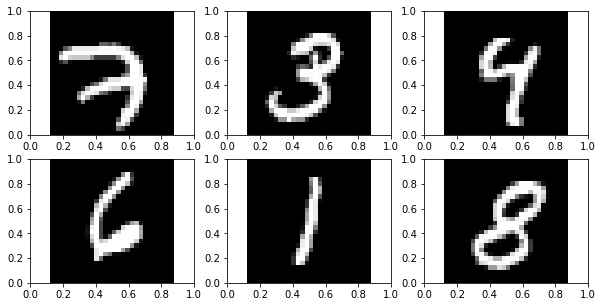

In [3]:
plt.clf()
fig, ax = plt.subplots(2,3,figsize=(10,5))

for i in range(6):
    ax = fig.add_subplot(2, 3, i+1)
    ax.imshow(mnist.train.images[i].reshape(28,28),cmap="gray")
    ax.axis("off")
plt.show()

Labels are one hot encoded already (parameter one_hot when we input the data)

In [4]:
mnist.train.labels[:6]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.]])

Let's program a function that gives a given number of examples. A batch.

In [5]:
def get_batches(X,Y,batch_size):
    '''
    Get batches of data, input is features,target
    and batch_size, output is one minibatch
    '''
    iters = X.shape[0]//batch_size
    for i in range(0,iters):
        yield X[i*batch_size:(i+1)*batch_size],Y[i*batch_size:(i+1)*batch_size]

In [6]:
data_example = get_batches(mnist.train.images,mnist.train.labels,15)
print(next(data_example)[0].shape)

(15, 784)


Here I just check that my self programmed function is faster in getting the batches than the built-in function next_batch in mnist.train.

In [12]:
%%time
batch_size=20
for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)

CPU times: user 76.7 ms, sys: 57.4 ms, total: 134 ms
Wall time: 133 ms


In [11]:
%%time
data_example = get_batches(mnist.train.images,mnist.train.labels,batch_size)
for x_,y_ in data_example:
    pass

CPU times: user 2.98 ms, sys: 12.6 ms, total: 15.6 ms
Wall time: 15.5 ms


My approach seems to be one order of magnitude faster. 

## Logistic regression

In [7]:
with tf.name_scope('input'):
    X = tf.placeholder(tf.float32, [None, 784],name="X")
    Y = tf.placeholder(tf.float32, [None, 10],name="Y")

with tf.name_scope('parameters'):
    W = tf.Variable(tf.truncated_normal([784, 10]),name="W")
    b = tf.Variable(tf.truncated_normal([10]),name="b")
    
with tf.name_scope('prediction'):
    y = tf.nn.softmax(tf.matmul(X, W) + b)

cross_entropy = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(y), reduction_indices=[1]))

In [8]:
learning_rate = 0.05 #learning rate, too big will cause NaNs.
batch_size = 20 #size to input the model, max is mnist.train.images.shape[0], the full data
epochs = 100 #number of epochs (times we pass trhough all the training data)
display_step = 5 #every how many steps we display the accuracy

prediction = tf.argmax(Y,1)
label = tf.argmax(y,1)

correct_prediction = tf.equal(label, prediction)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y,labels=Y))
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)

#saver
saver = tf.train.Saver()

#to show in tensorboard
summary_acc = tf.summary.scalar(name="acc",tensor=accuracy)

In [9]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    writer = tf.summary.FileWriter("./tmp", graph=sess.graph)
    for epoch in range(epochs):
        data = get_batches(X=mnist.train.images,Y=mnist.train.labels,batch_size=batch_size)
        for x_,y_ in data:
            sess.run(train_step,feed_dict = {X:x_,Y:y_})
        
        if epoch % display_step == 0:
            print("epoch: {}, accuracy:{}, cross_entropy:{}".format(epoch,
                sess.run(accuracy,feed_dict={X:mnist.test.images,Y:mnist.test.labels}),
                sess.run(cross_entropy,feed_dict = {X:mnist.test.images,Y:mnist.test.labels})))
            
        summary = sess.run(summary_acc,feed_dict={Y : mnist.train.labels,X : mnist.train.images})
        writer.add_summary(summary, epoch)
        
    save_path = saver.save(sess, "./tmp/logistic_regression_model.ckpt")
    print("Model saved in path: {}".format(save_path))


epoch: 0, accuracy:0.8427000045776367, cross_entropy:0.7019758224487305
epoch: 5, accuracy:0.8939999938011169, cross_entropy:0.41914820671081543
epoch: 10, accuracy:0.9038000106811523, cross_entropy:0.3712257444858551
epoch: 15, accuracy:0.9077000021934509, cross_entropy:0.348800390958786
epoch: 20, accuracy:0.9110999703407288, cross_entropy:0.3350515067577362
epoch: 25, accuracy:0.9129999876022339, cross_entropy:0.3255474269390106
epoch: 30, accuracy:0.9139999747276306, cross_entropy:0.3185526728630066
epoch: 35, accuracy:0.9157000184059143, cross_entropy:0.31321167945861816
epoch: 40, accuracy:0.9178000092506409, cross_entropy:0.30902886390686035
epoch: 45, accuracy:0.917900025844574, cross_entropy:0.3056904673576355
epoch: 50, accuracy:0.9187999963760376, cross_entropy:0.3029852509498596
epoch: 55, accuracy:0.919700026512146, cross_entropy:0.30076634883880615
epoch: 60, accuracy:0.9207000136375427, cross_entropy:0.2989278733730316
epoch: 65, accuracy:0.9204999804496765, cross_entrop

Final accuracy: 0.9212999939918518
The number is [8] and the predicted is [8]


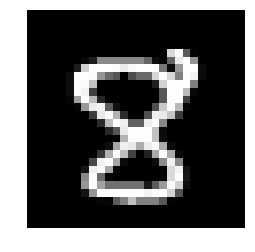

In [10]:
with tf.Session() as sess:
    saver.restore(sess, "./tmp/logistic_regression_model.ckpt")
    print("Final accuracy: {}".format(sess.run(accuracy,feed_dict = {X:mnist.test.images,Y:mnist.test.labels})))
    
    rdm_index = np.random.choice(len(mnist.test.images))
    
    x = mnist.test.images[rdm_index].reshape(1,784)
    y = mnist.test.labels[rdm_index].reshape(1,10)
    
    pred = sess.run(prediction,feed_dict={X:x,Y:y})
    lab = sess.run(label,feed_dict={X:x,Y:y})
    
    print("The number is {} and the predicted is {}".format(lab,pred))
    
    plt.clf()
    plt.imshow(mnist.test.images[rdm_index].reshape(28,28),cmap="gray")
    plt.axis("off")
    plt.show()

In [11]:
mnist.test.images.shape[0]

10000